In [1]:
from pathlib import Path

import torch
from torch.utils import data
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl

from dataclasses import dataclass
from typing import Iterable
import xarray as xr
from concurrent import futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nowcasting_dataloader.data_sources.satellite.satellite_model import SAT_MEAN, SAT_STD

In [2]:
DATA_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15")

SATELLITE_CHANNELS = (
    "IR_016",
    "IR_039",
    "IR_087",
    "IR_097",
    "IR_108",
    "IR_120",
    "IR_134",
    "VIS006",
    "VIS008",
    "WV_062",
    "WV_073",
)

In [3]:
def satellite_normalisation_stats_to_data_array(stat: dict) -> xr.DataArray:
    return xr.DataArray(
        [stat[chan_name] for chan_name in SATELLITE_CHANNELS],
        dims="channels_index",
    ).astype(np.float32)

SAT_MEAN = satellite_normalisation_stats_to_data_array(SAT_MEAN)
SAT_STD = satellite_normalisation_stats_to_data_array(SAT_STD)

In [4]:
def align_time(src: xr.Dataset, dst: xr.Dataset) -> xr.DataArray:
    """Align `dst` to have the same `time` coords as `src.time`.
    
    For example, use this to ensure that batch['opticalflow'] has the same
    time coords as batch['gsp'].
    """
    # I tried a bunch of "vectorised" ways of doing this.  This appears to be the
    # only way of doing it.  The issue is that each example ends up having different
    # time_index coords so, in order to align, we must reset the "time_index" of each example.
    time_index_bool_mask = dst.time.isin(src.time)
    data_arrays_for_examples = []
    n_examples = len(time_index_bool_mask)
    for example_i in range(n_examples):
        selection = dst["data"].isel(example=example_i, time_index=time_index_bool_mask[example_i])
        selection.__setitem__("time_index", np.arange(len(selection["time_index"])))
        data_arrays_for_examples.append(selection)
        
    new_dst = xr.concat(data_arrays_for_examples, dim="example")
    return new_dst

In [5]:
@dataclass
class SimpleNowcastingDataset(data.Dataset):
    """
    Attributes:
        data_path: Base path to the pre-prepared dataset.  e.g. .../v15/train/
        data_source_names: The names of the data sources.  Must also be the names of the subdirectory.  
            Must include "gsp".
        gsp_first_time_index_of_future: The index into the GSP time_index dimension that marks the start of the "future".
        n_batches: The number of available batches.
    """
    data_path: Path
    data_source_names: Iterable[str]
    gsp_first_time_index_of_future: int = 2
    
    def __post_init__(self):
        # Sanity checks
        assert self.data_path.exists()
        assert len(self.data_source_names) > 0
        assert "gsp" in self.data_source_names
        self.n_batches = self._get_number_of_batches()
        
    def _get_number_of_batches(self) -> int:
        """Get number of batches.  Check every data source."""
        n_batches = None
        for data_source_name in self.data_source_names:
            path_for_data_source = self.data_path / data_source_name
            n_batches_for_data_source = len(list(path_for_data_source.glob("*.nc")))
            if n_batches is None:
                n_batches = n_batches_for_data_source
            else:
                assert n_batches == n_batches_for_data_source
        assert n_batches is not None
        assert n_batches > 0
        return n_batches
    
    def __len__(self) -> int:
        return self.n_batches
    
    def __getitem__(self, idx: int):
        """
        Returned shapes:
            gsp: batch_size, n_timesteps
            opticalflow: "example", "time_index", "channels_index",  "y_index", "x_index"
        """
        data_from_all_sources = {}
        # Parallelising this with concurrent.futures.ThreadPoolExecutor actually
        # appears to be _slower_ than the simple loop approach!
        for data_source_name in self.data_source_names:
            filename = self.data_path / data_source_name / f"{idx:06d}.nc"
            dataset = xr.open_dataset(filename)
            
            # Select just the "future" timesteps at half-hour intervals (t1, t2, etc.)
            # for the first GSP (the "target").
            if data_source_name == "gsp":
                dataset = dataset.isel(
                    time_index=slice(self.gsp_first_time_index_of_future, None),
                    id_index=0
                ).load()
                # Normalise GSP
                dataset["data"] = dataset["power_mw"] / dataset["capacity_mwp"]
                dataset["data"] = dataset["data"].astype(np.float32)
                
            if data_source_name == "pv":
                dataset = dataset.isel(time_index=slice(None, 7))
                dataset["data"] = dataset["power_mw"] / dataset["capacity_mwp"]
            
            if data_source_name in ["satellite", "opticalflow"]:
                # Normalise satellite and opticalflow
                dataset["data"] = dataset["data"].astype(np.float32)
                dataset["data"] -= SAT_MEAN
                dataset["data"] /= SAT_STD
                dataset["data"] = dataset["data"].transpose("example", "time_index", "channels_index", "y_index", "x_index")

            data_from_all_sources[data_source_name] = dataset

        # Conform all other data sources to have the same time index as GSP
        for data_source_name in self.data_source_names:
            if data_source_name not in ["gsp", "pv"]:
                data_from_all_sources[data_source_name] = align_time(
                    src=data_from_all_sources["gsp"],
                    dst=data_from_all_sources[data_source_name].load())
                
        # Strip away everything that's not required by the PyTorch model
        for data_source_name in self.data_source_names:
            data = data_from_all_sources[data_source_name]
            if data_source_name == "gsp":
                data_from_all_sources["gsp_id"] = torch.from_numpy(data["id"].values.astype(np.int32))
                data = data["data"]
                
            if data_source_name == "pv":
                data_from_all_sources["pv_system_id"] = torch.from_numpy(data["id"].values.astype(np.float32))
                data_from_all_sources["pv_x_coords"] = torch.from_numpy(data["x_coords"].values.astype(np.float32))
                data_from_all_sources["pv_y_coords"] = torch.from_numpy(data["y_coords"].values.astype(np.float32))
                data = data["data"]

            data_from_all_sources[data_source_name] = torch.from_numpy(data.values)

        return data_from_all_sources

In [6]:
train_dataset = SimpleNowcastingDataset(
    data_path=DATA_PATH / "train",
    data_source_names=("opticalflow", "gsp"),
)

In [7]:
len(train_dataset)

4000

In [8]:
%%time
batch = train_dataset[16]

CPU times: user 394 ms, sys: 39 ms, total: 433 ms
Wall time: 436 ms


128

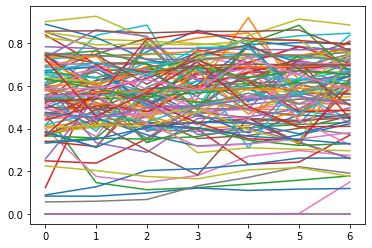

In [45]:
len(plt.plot(batch["pv"][0]))

In [9]:
batch["opticalflow"].shape

torch.Size([32, 4, 11, 24, 24])

In [9]:
from itertools import chain

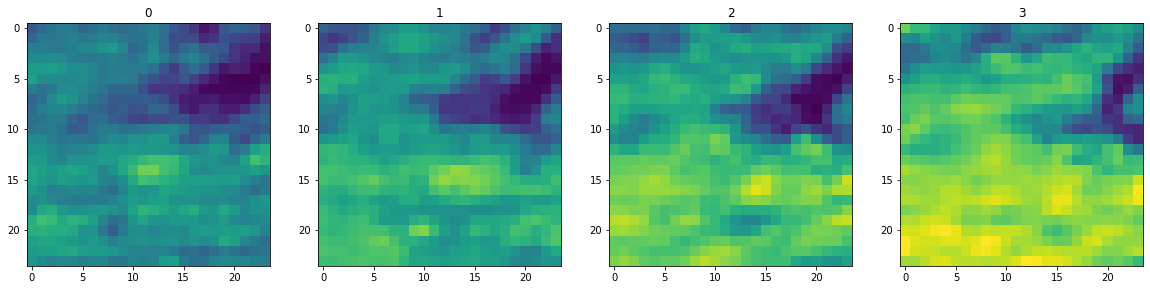

In [10]:
def plot_imagery(tensor, example_i, channel_i):
    fig, axes = plt.subplots(ncols=4, figsize=(20, 10))
    # axes = list(chain.from_iterable(axes))
    # "example", "time_index", "channels_index", "y_index", "x_index"
    data_to_plot = tensor[example_i, :4, channel_i, :, :]
    vmin = data_to_plot.min()
    vmax = data_to_plot.max()
    for time_index, ax in enumerate(axes):
        ax.imshow(data_to_plot[time_index].numpy()[::-1], vmin=vmin, vmax=vmax)
        ax.set_title(time_index)
    return fig, axes

EXAMPLE_I = 1
CHANNEL_I = 8
plot_imagery(batch["satellite"], example_i=EXAMPLE_I, channel_i=CHANNEL_I);

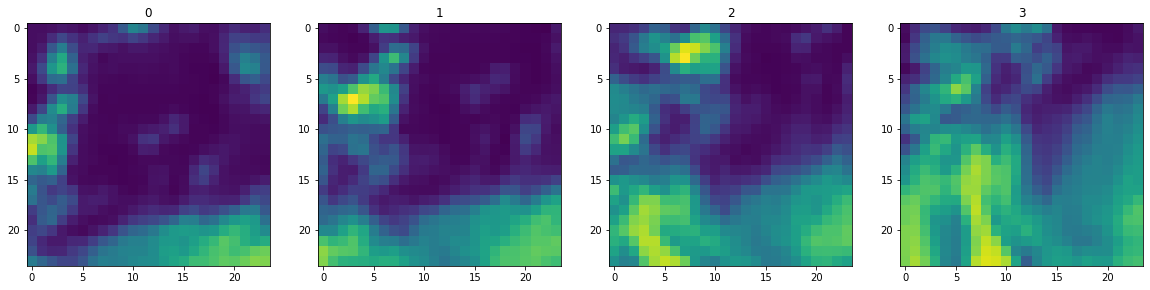

In [12]:
plot_imagery(batch["opticalflow"], example_i=EXAMPLE_I, channel_i=CHANNEL_I);

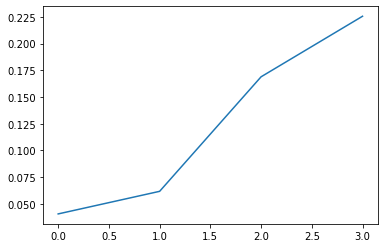

In [11]:
plt.plot(batch["gsp"][EXAMPLE_I]);

## Put the dataset into a DataLoader

In [8]:
train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=None,
    #prefetch_factor=8,
    num_workers=12,
    pin_memory=True
)

In [ ]:
%%time
for batch in train_dataloader:
    break

# Define the ML model

Each input "row" to the Perceiver will look like this:

Shape: batch_size, seq_len, embedding_dim

Try to keep the constant-length things in the same position.  e.g. the modality embedding always comes first.  The position encoding always comes second (for modalities which have spatial positions).

* Opticalflow: (just one channel at a time)
    - learnt modality embedding (4)
    - relative x and y position encoding (16)
    - 4x4 patch of pixel values (16)
    - learnt channel embedding (4)
* PV:
    - learnt modality embedding (4)
    - relative x and y position encoding (16)
    - entire historical timeseries for one PV system (7)
    - learnt PV ID embedding (13)
* Datetime:
    - learnt modality embedding (4)
    - all timesteps for forecast (4) x 9 features
* The learnt "query" to the Perceiver:
    - Embedding of the GSP ID?

In [ ]:
import math

In [ ]:
def position_encoding(n_encoding_channels: int, seq_length: int = 24, period: float = 5.0) -> torch.Tensor:
    """
    Args:
       n_encoding_channels: The number of "waves" in the encoding.
       seq_length: The sequence length.
       period: A rough specification for the period.  The larger the number, 
           the longer the period of the longest sin and cos waves.
           
    Returns:
        Tensor of shape (seq_length, n_encoding_channels)
    Adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    position = torch.arange(seq_length).unsqueeze(1) * 2
    div_term = torch.exp(torch.arange(0, n_encoding_channels, 2) * (-math.log(period) / n_encoding_channels))
    pe = torch.empty(seq_length, n_encoding_channels)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

In [ ]:
%%time
pe = position_encoding(n_encoding_channels=8, seq_length=6, period=3)

In [ ]:
pe.shape

In [ ]:
plt.plot(pe);

In [ ]:
import einops

In [ ]:
class Model(pl.LightningModule):
    def __init__(
        self, 
        embed_dim_query: int = 128,  # TODO: Play with this number
        num_elements_query: int = 32,
        num_heads: int = 16,
        num_latent_transformer_encoder_layers: int = 4,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.embed_dim_query = embed_dim_query
        self.num_elements_query = num_elements_query
        
        # Create position encoding vectors
        self.register_buffer(
            "position_encoding", 
            position_encoding(n_encoding_channels=8, seq_length=6, period=3))
        
        # PERCEIVER #################################
        # Layers for the Perceiver model:
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=embed_dim_query,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
            kdim=36,
            vdim=36
        )
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim_query,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.latent_transformer = nn.TransformerEncoder(
            encoder_layer=transformer_encoder_layer,
            num_layers=num_latent_transformer_encoder_layers,
        )
        
        
        # Linear output layers #################################
        self.output_layers = nn.Sequential(
            nn.Linear(in_features=num_elements_query * embed_dim_query, out_features=embed_dim_query),
            nn.ReLU(),
            nn.Linear(in_features=embed_dim_query, out_features=1),
        )
        
        self.satellite_chan_embedding = nn.Embedding(
            num_embeddings=11,  # number channels
            embedding_dim=4,
        )
        
        # EMBEDDING THE GSP ID AND USE THAT AS THE LEARNABLE QUERY ######################
        self.gsp_id_embedding = nn.Embedding(
            num_embeddings=350,  # number of GSPs
            embedding_dim=16,
        )
        self.query_generator = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=num_elements_query * embed_dim_query),
            nn.ReLU(),
        )
        
    def forward(self, batch: dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Args:
            batch: Contains these keys:
                - opticalflow: Shape: batch_size, time, "channels_index", "y_index", "x_index"
                
        Returns:
            Tensor of shape batch_size, time
        """
        #######################################################
        # GET DATA INTO THE RIGHT SHAPE #######################
        opticalflow = batch["opticalflow"][:, :4]
        original_batch_size, original_seq_len = opticalflow.shape[:2]
        
        # Select just one channel for now
        # opticalflow = opticalflow[:, :, 7:8]
        
        # Reshape so each timestep is seen as a separate example
        opticalflow = einops.rearrange(opticalflow, "b t c h w -> (b t) c h w")
        
        # Take 4x4 patches of pixels:
        # Adapted from https://github.com/openclimatefix/satflow/blob/main/satflow/models/utils.py#L54
        opticalflow = einops.rearrange(opticalflow, "b c (h dh) (w dw) -> b c h w (dh dw)", dh=4, dw=4)
        
        b, c, h, w, d = opticalflow.shape
        
        # Encode the channel
        chan_list = torch.arange(c, device=opticalflow.device)
        embedded_chan_list = self.satellite_chan_embedding(chan_list)    
    
        # Concat position encoding for the height and width:
        opticalflow = torch.cat(
            (
                # Position encode the height:
                # ("d" is the dimensionality of the Perceiver model)
                einops.repeat(self.position_encoding, "h d -> b c h w d", b=b, c=c, w=w),
                # Position encode the width:
                einops.repeat(self.position_encoding, "w d -> b c h w d", b=b, c=c, h=h),
                opticalflow,
                einops.repeat(embedded_chan_list, "c d -> b c h w d", b=b, c=c, h=h, w=w),
            ),
            dim=-1)
        # opticalflow now has shape: b, c, h, w, d_model
        # e.g. 128, 10, 6, 6, 32
        
        # Reshape into batch_size, perceiver row, d_model ready for the perceiver
        opticalflow = einops.rearrange(opticalflow, "b c h w d -> b (c h w) d")
        
        #######################################################
        # CROSS ATTENTION! ####################################
        
        # Create query
        # num_elements is the number of elements in the set that's fed into cross attention
        # Embed the GSP ID 
        query = self.gsp_id_embedding(batch["gsp_id"])
        # Then put the embedding through a linear layer so the model can learn different queries
        # for each element of the Transformer's input.
        query = self.query_generator(query)
        # Repeat for each timestep:
        query = torch.repeat_interleave(query, repeats=original_seq_len, dim=0)
        query = query.squeeze()
        query = einops.repeat(
            query, 
            "b (num_elements embed_dim) -> b num_elements embed_dim", 
            b=b, 
            num_elements=self.num_elements_query,
            embed_dim=self.embed_dim_query,
        )
        attn_output, attn_weights = self.cross_attention(query, key=opticalflow, value=opticalflow, need_weights=False)
        del attn_weights  # Not used yet.
        
        # LATENT TRANSFORMER
        attn_output = self.latent_transformer(attn_output)
        
        # LINEAR LAYERS
        out = self.output_layers(einops.rearrange(attn_output, "b s d -> b (s d)"))
        
        # Reshape back to b, t, 1
        return einops.rearrange(out, "(b t) 1 -> b t 1", b=original_batch_size, t=original_seq_len)

    def training_step(self, batch, batch_idx):
        actual_gsp_power = batch["gsp"].unsqueeze(-1)
        predicted_gsp_power = self(batch)
        loss = F.mse_loss(predicted_gsp_power, actual_gsp_power)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [ ]:
model = Model()

In [ ]:
model(batch).shape

In [ ]:
trainer = pl.Trainer(gpus=1)
trainer.fit(model, train_dataloader)

In [19]:
# Next: 
# 1) Log stuff to Neptune.  Including timeseries plots
# 2) Add historical PV.  And datetime features.  And then NWPs.

In [ ]:
#